# CNN Waste Classification

## Introduction

Purpose, goal, context, blah blah blah

## Data Pre-Processing

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
#!pip install torch -- uncomment first time you run
import seaborn as sns
#!pip install torch -- uncomment first time you run
import torch
#!pip install torchvision -- uncomment first time you run
import torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.datasets import ImageFolder

In [3]:
# Define set of transformations- convert image to PyTorch tensor, scale pixels from 0-255 to 0.0 - 1.0, normalizes pixels to -1.0 - 1.0
# Output is a (3, 256, 256) array --> Color channels 0.0 - 1.0 and the dimensions 256x256
transform_scratch = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [4]:
# Load in the dataset and apply the transform
from torchvision.datasets import ImageFolder

full_dataset = ImageFolder(root="images/", transform=transform_scratch)
print(f"Total images: {len(full_dataset)}") # Print number of images
print(f"Class labels: {full_dataset.classes}") # Print all of the class labels

Total images: 15000
Class labels: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


## Define Data Splits

-- **NOTES** --

Here we can mess around with different training splits such as 
- Random split
- Evenly divide each sub-category (Stratified)
- Evenly divide each sub-category AND default/real world images (Double Stratified)
- Train more on default images, test more on real world (Studio Train)

All of these are implemented below. Maybe we start with either random or double stratified but can test out all going forward.

In [5]:
from torch.utils.data import random_split
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

import numpy as np

# Set the split sizes
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size) # TRAIN proportion = 0.7
val_size = int(0.15 * dataset_size) # VALIDATION proportion = 0.15
test_size = dataset_size - train_size - val_size  # TEST proportion = 0.15

##### RANDOMLY split the dataset #####
random_train_dataset, random_val_dataset, random_test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Random Train size: {len(random_train_dataset)}")
print(f"Random Validation size: {len(random_val_dataset)}")
print(f"Random Test size: {len(random_test_dataset)}\n")

##### STRATIFIED SPLIT (Evenly distribute each category between the train, val, test proportions) #####
## Get all targets from the dataset
targets = np.array(full_dataset.targets)

# 1st split: Separate 70% training data and 30% temp (which will become val + test)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(splitter.split(np.zeros(len(targets)), targets))

# Use class labels from the temp split to do a second stratified split (val and test)
temp_targets = targets[temp_idx]

# 2nd split: Split the 30% temp into 15% val and 15% test
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(splitter2.split(np.zeros(len(temp_idx)), temp_targets))

# Since val/test indices refer to the temp set, map them back to the full dataset
val_idx = temp_idx[val_idx]
test_idx = temp_idx[test_idx]

# Create PyTorch Subset objects for each split, using the final indices
strat_train_dataset = Subset(full_dataset, train_idx)
strat_val_dataset = Subset(full_dataset, val_idx)
strat_test_dataset = Subset(full_dataset, test_idx)

# Print sizes again
print(f"Stratified Train size: {len(strat_train_dataset)}")
print(f"Stratified Validation size: {len(strat_val_dataset)}")
print(f"Stratified Test size: {len(strat_test_dataset)}\n")

##### DOUBLE STRATIFIED SPLIT (Evenly distribute each category and real world vs default between train/val/test) #####
# Step 1: Create a list of full file paths for all images
all_paths = [full_dataset.samples[i][0] for i in range(len(full_dataset))]

# Step 2: Create a combined stratification label for each image: e.g., "plastic_water_bottles__default"
combined_labels = []
for path in all_paths:
    # Example path: images/plastic_water_bottles/default/image1.png
    parts = path.split(os.sep)
    category = parts[-3]  # e.g., plastic_water_bottles
    subtype = parts[-2]   # e.g., default or real_world
    combined_label = f"{category}__{subtype}"
    combined_labels.append(combined_label)

combined_labels = np.array(combined_labels)

# Step 3: First split: 70% train, 30% temp (val + test)
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(split1.split(np.zeros(len(combined_labels)), combined_labels))

# Step 4: Second split: split temp into 50% val, 50% test (i.e., 15% each overall)
temp_labels = combined_labels[temp_idx]
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(split2.split(np.zeros(len(temp_labels)), temp_labels))

# Map relative val/test indices back to full dataset indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

# Step 5: Create PyTorch Subsets
double_strat_train_dataset = Subset(full_dataset, train_idx)
double_strat_val_dataset = Subset(full_dataset, val_idx)
double_strat_test_dataset = Subset(full_dataset, test_idx)

# Optional sanity check
print(f"Double Stratified Train size: {len(double_strat_train_dataset)}")
print(f"Double Stratified Validation size: {len(double_strat_val_dataset)}")
print(f"Double Stratified Test size: {len(double_strat_test_dataset)}\n")

##### DEFAULT v REAL WORLD TRAIN SPLIT (All default goes to train, real_world fills in remaining train, then val & test) #####
# Map: class index → class name (e.g., 0 → 'plastic_water_bottles')
# Map class index → class name (e.g., 0 → 'plastic_water_bottles')
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

# Split default and real_world
default_indices = []
realworld_indices = []

for i, (path, class_idx) in enumerate(full_dataset.samples):
    subtype = path.split(os.sep)[-2]  # 'default' or 'real_world'
    if subtype == "default":
        default_indices.append(i)
    elif subtype == "real_world":
        realworld_indices.append(i)

# Calculate dataset sizes
total_size = len(full_dataset)
target_train_size = int(0.7 * total_size)
target_val_size = int(0.15 * total_size)
target_test_size = total_size - target_train_size - target_val_size

# Use all default images in training set
train_idx = set(default_indices)

# How many more real_world images needed for train?
remaining_needed = target_train_size - len(train_idx)

# Sanity check
if remaining_needed < 0:
    raise ValueError("Too many default images to satisfy 70% train split!")

# Convert to array
realworld_indices = np.array(realworld_indices)

# First: get required real_world images for training
rw_train_idx, rw_temp_idx = train_test_split(
    realworld_indices,
    train_size=remaining_needed,
    random_state=42,
    shuffle=True
)

# Second: split the rest equally into val and test
rw_val_idx, rw_test_idx = train_test_split(
    rw_temp_idx,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

# Final index sets
train_idx.update(rw_train_idx)
val_idx = set(rw_val_idx)
test_idx = set(rw_test_idx)

# Create subsets
drw_train_dataset = Subset(full_dataset, sorted(train_idx))
drw_val_dataset = Subset(full_dataset, sorted(val_idx))
drw_test_dataset = Subset(full_dataset, sorted(test_idx))

# Print final sizes
print(f"DRW Train size: {len(drw_train_dataset)}")
print(f"DRW Validation size: {len(drw_val_dataset)}")
print(f"DRW Test size: {len(drw_test_dataset)}")

Random Train size: 10500
Random Validation size: 2250
Random Test size: 2250

Stratified Train size: 10500
Stratified Validation size: 2250
Stratified Test size: 2250

Double Stratified Train size: 10500
Double Stratified Validation size: 2250
Double Stratified Test size: 2250

DRW Train size: 10500
DRW Validation size: 2250
DRW Test size: 2250


### Implement Data Loader

In [8]:
from torch.utils.data import DataLoader

# Use data loader to improve efficiency of loading data during training
batch_size = 32  # Can be adjusted

# shuffle = True : Ensures all images from a category aren't trained on consecutively
random_train_loader = DataLoader(random_train_dataset, batch_size=batch_size, shuffle=True) 
random_val_loader = DataLoader(random_val_dataset, batch_size=batch_size, shuffle=False)
random_test_loader = DataLoader(random_test_dataset, batch_size=batch_size, shuffle=False)


double_strat_train_loader = DataLoader(double_strat_train_dataset, batch_size=batch_size, shuffle=True) 
double_strat_train_loader = DataLoader(double_strat_val_dataset, batch_size=batch_size, shuffle=False)
double_strat_train_loader = DataLoader(double_strat_test_dataset, batch_size=batch_size, shuffle=False)


# Testing Basic CNNs

### (1) TRAINING: random train/test split used, lr = .001, no overfitting methods used, 5 epochs, target 30 categories 

### (1) MODEL: 3 conv+pool layers, max pool 2x2 (halves image size) from 256 --> 128 --> 64 --> 32, 2 fully connected layers, fc1 input=131,072 output=256, fc2 input=256, output=30, RELU, kernel size = 3x3 (SAME for all in this section)

In [14]:
# ----------------------
# IMPORTS
# ----------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----------------------
# DEVICE SETUP
# ----------------------
# Automatically selects GPU if available, otherwise uses CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# MODEL DEFINITION
# ----------------------
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        # Convolutional layers to learn spatial features
        super(WasteClassifierCNN, self).__init__()
        #Format is (Channels In, Channels Out, Size of Filter, Padding)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # Input: RGB (3 channels)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Max pooling layer to reduce spatial resolution
        self.pool = nn.MaxPool2d(2, 2) # Halves width and height each time

        # After 3 poolings: 256x256 → 128 → 64 → 32 ⇒ final feature map: [128 x 32 x 32]
        self.flattened_size = 128 * 32 * 32 # Total number of features before FC layers

        # Fully connected layers to classify based on extracted features
        self.fc1 = nn.Linear(self.flattened_size, 256) # Hidden layer
        self.fc2 = nn.Linear(256, num_classes) # Output layer

    def forward(self, x):
        # Apply convolutions, activation, and pooling in sequence
        x = self.pool(F.relu(self.conv1(x))) # Output: [B, 32, 128, 128] --> (Batch Size, Channels, Height, Width)
        x = self.pool(F.relu(self.conv2(x))) # Output: [B, 64, 64, 64]
        x = self.pool(F.relu(self.conv3(x))) # Output: [B, 128, 32, 32]

        # Flatten the feature maps into a 1D vector
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x)) # Hidden representation
        x = self.fc2(x) # Final classification logits
        return x

# ----------------------
# MODEL INITIALIZATION
# ----------------------
num_classes = len(full_dataset.classes) # Automatically get number of classes
model = WasteClassifierCNN(num_classes=num_classes).to(device) # Move Model to CPU

# ----------------------
# LOSS FUNCTION & OPTIMIZER
# ----------------------
criterion = nn.CrossEntropyLoss() # Loss for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adaptive optimizer

# ----------------------
# TRAINING LOOP WITH VALIDATION TRACKING
# ----------------------
num_epochs = 5 # Number of full passes through the training data

# DataLoaders using random split
train_loader = random_train_loader
val_loader = random_val_loader  

# Dictionary to keep track of losses for plotting
history = {
    "loss": [],
    "val_loss": []
}

# Loop over each epoch
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0  # Track correct predictions
    total = 0  # Track total predictions

    print(f"\nEpoch {epoch+1}/{num_epochs}")  #Nicely formatted print statement

    # Loop over training batches with progress bar
    loop = tqdm(train_loader, total=len(train_loader), leave=True, ncols=100)

    for images, labels in loop:

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar with running accuracy and loss
        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

     # Average loss over all batches for this epoch
    avg_train_loss = running_loss / len(train_loader)
    history["loss"].append(avg_train_loss)

    # ----------------------
    # VALIDATION STEP
    # ----------------------

    # Set model to evaluation mode
    model.eval()
    val_loss = 0.0

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Average validation loss across all batches
    avg_val_loss = val_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)

     # Print both losses side-by-side for review
    print(f"→ Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

Using device: cpu

Epoch 1/5


100%|████████████████████████████████████| 329/329 [04:45<00:00,  1.15it/s, acc=0.2290, loss=2.7763]


→ Training Loss: 2.7763 | Validation Loss: 2.2617

Epoch 2/5


100%|████████████████████████████████████| 329/329 [04:55<00:00,  1.11it/s, acc=0.4850, loss=1.8398]


→ Training Loss: 1.8398 | Validation Loss: 1.9563

Epoch 3/5


100%|████████████████████████████████████| 329/329 [05:08<00:00,  1.07it/s, acc=0.6719, loss=1.1710]


→ Training Loss: 1.1710 | Validation Loss: 1.8070

Epoch 4/5


100%|████████████████████████████████████| 329/329 [05:10<00:00,  1.06it/s, acc=0.8141, loss=0.6292]


→ Training Loss: 0.6292 | Validation Loss: 1.9434

Epoch 5/5


100%|████████████████████████████████████| 329/329 [05:12<00:00,  1.05it/s, acc=0.9047, loss=0.3208]


→ Training Loss: 0.3208 | Validation Loss: 2.1914


### Check for Overfitting

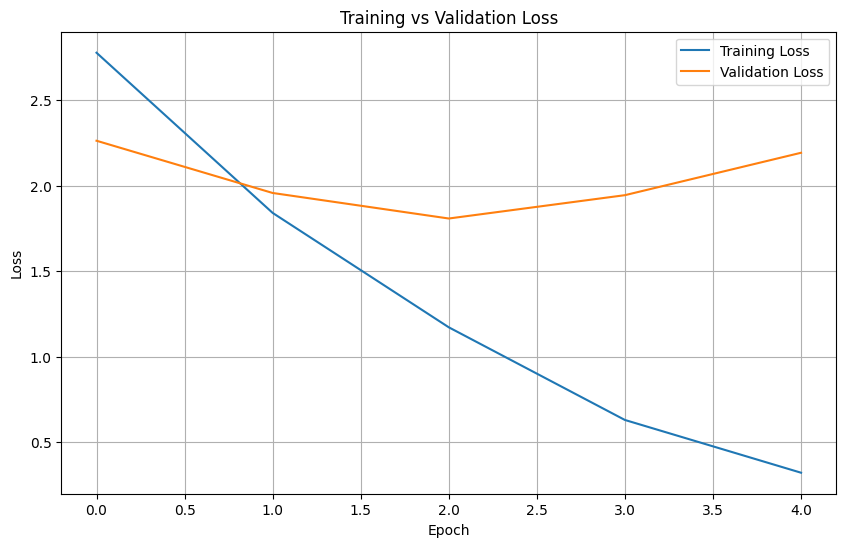

In [15]:
# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### Construct a Confusion Matrix

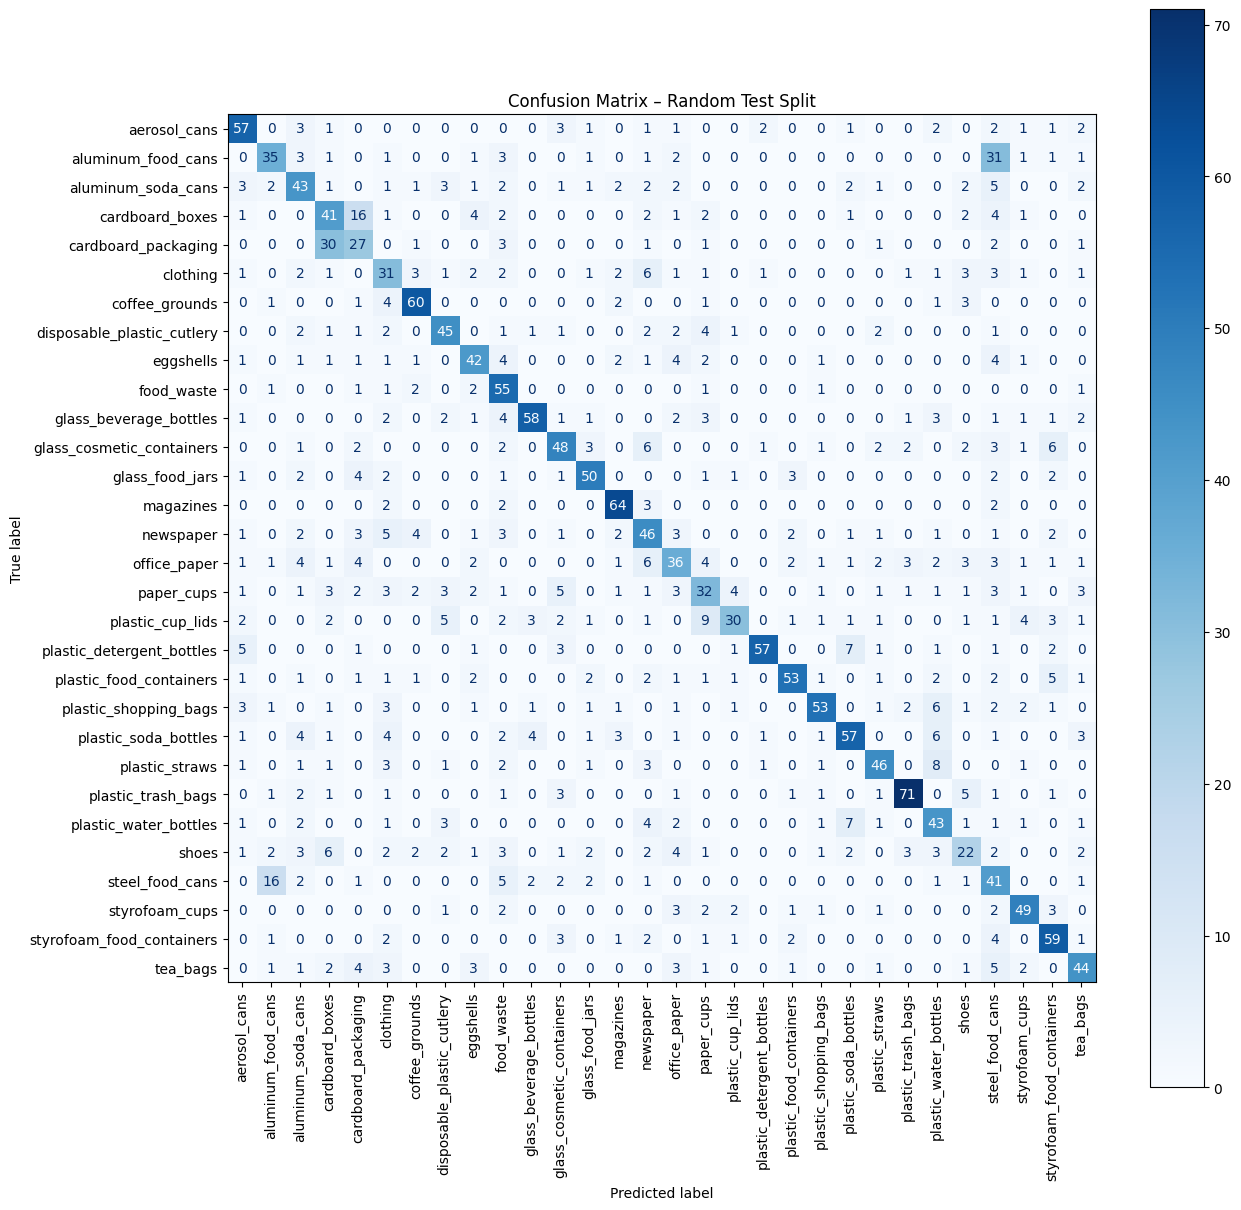

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set the model to evaluation mode (disables dropout/batchnorm behavior)
model.eval()

# Lists to store predicted and true labels
all_preds = []
all_labels = []

# Disable gradient calculation for inference (faster and uses less memory)
with torch.no_grad():
    # Loop through the test data loader from the random split
    for images, labels in random_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
         # Perform a forward pass through the model to get predictions
        outputs = model(images)
        
        # Get the predicted class with the highest probability
        _, predicted = torch.max(outputs, 1)

        # Store predictions and true labels (move them to CPU and convert to numpy)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix based on all test predictions vs actual labels
cm = confusion_matrix(all_labels, all_preds)

# Create a confusion matrix display (labelled with class names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)

# Plot
fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix – Random Test Split")
plt.show()


### Check Accuracy by Category

In [17]:
# Initialize lists
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    
    # Loop through batches in the test set
    for images, labels in random_test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass to get model predictions
        outputs = model(images) 
        _, predicted = torch.max(outputs, 1) # Get class index with the highest logit for each image

        # Compare predictions with true labels for each item in the batch
        for label, prediction in zip(labels, predicted):
            class_total[label] += 1
            if label == prediction:
                class_correct[label] += 1

print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-"*40)
for i, class_name in enumerate(full_dataset.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")



🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 73.08%
aluminum_food_cans             — Accuracy: 42.68%
aluminum_soda_cans             — Accuracy: 55.84%
cardboard_boxes                — Accuracy: 52.56%
cardboard_packaging            — Accuracy: 40.30%
clothing                       — Accuracy: 47.69%
coffee_grounds                 — Accuracy: 82.19%
disposable_plastic_cutlery     — Accuracy: 68.18%
eggshells                      — Accuracy: 62.69%
food_waste                     — Accuracy: 84.62%
glass_beverage_bottles         — Accuracy: 69.05%
glass_cosmetic_containers      — Accuracy: 60.00%
glass_food_jars                — Accuracy: 71.43%
magazines                      — Accuracy: 87.67%
newspaper                      — Accuracy: 58.23%
office_paper                   — Accuracy: 45.00%
paper_cups                     — Accuracy: 42.11%
plastic_cup_lids               — Accuracy: 42.25%
plastic_detergent_bottles 

### Total Accuracy

In [18]:
correct = sum(class_correct)
total = sum(class_total)
overall_acc = 100 * correct / total
print(f"\n✅ Overall Test Accuracy: {overall_acc:.2f}%")


✅ Overall Test Accuracy: 62.00%


## Model 2: Same Model, Implement Early Stopping, L2 Regularization and Dropout. Train for 10 epochs

In [21]:
##ANTI-OVERFITTING

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model with Dropout
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.dropout = nn.Dropout(p=0.5) # Randomly zeroes 50% of neurons during training
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Applies dropout during training only
        x = self.fc2(x)
        return x

# Initialize model
num_classes = len(full_dataset.classes)
model = WasteClassifierCNN(num_classes).to(device)

# Loss & Optimizer with L2 regularization (weight_decay)
criterion = nn.CrossEntropyLoss()

# L2 regularization is implemented by setting weight_decay
# Helps penalize large weights to reduce overfitting (larger means greater penalty for higher weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Loaders
train_loader = random_train_loader
val_loader = random_val_loader

# Training with Early Stopping
num_epochs = 10
patience = 2
best_val_loss = float('inf')
patience_counter = 0

history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, total=len(train_loader), leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    # Record training loss
    train_loss = running_loss / len(train_loader)
    history["loss"].append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss # Update best loss
        patience_counter = 0 # Reset counter if improvement
        torch.save(model.state_dict(), "best_model.pt") # Save model checkpoint
    else: 
        patience_counter += 1 # No improvement → increase patience counter
        if patience_counter >= patience: # Stop training if patience exhausted
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


Using device: cpu


Epoch 1 | Train Loss: 3.0239 | Val Loss: 2.5852


Epoch 2 | Train Loss: 2.5098 | Val Loss: 2.1863


Epoch 3 | Train Loss: 2.0506 | Val Loss: 1.9217


Epoch 4 | Train Loss: 1.6288 | Val Loss: 1.6435


Epoch 5 | Train Loss: 1.2602 | Val Loss: 1.5913


Epoch 6 | Train Loss: 0.9710 | Val Loss: 1.5255


Epoch 7 | Train Loss: 0.7387 | Val Loss: 1.5872


Epoch 8 | Train Loss: 0.6368 | Val Loss: 1.6195
Early stopping triggered after 8 epochs.


### Training vs Validation Plot

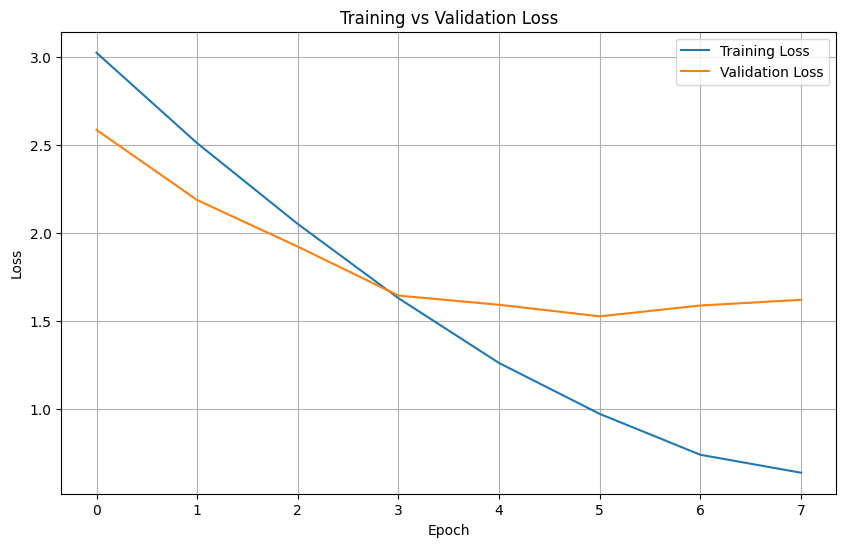

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### Confusion Matrix for Model 2

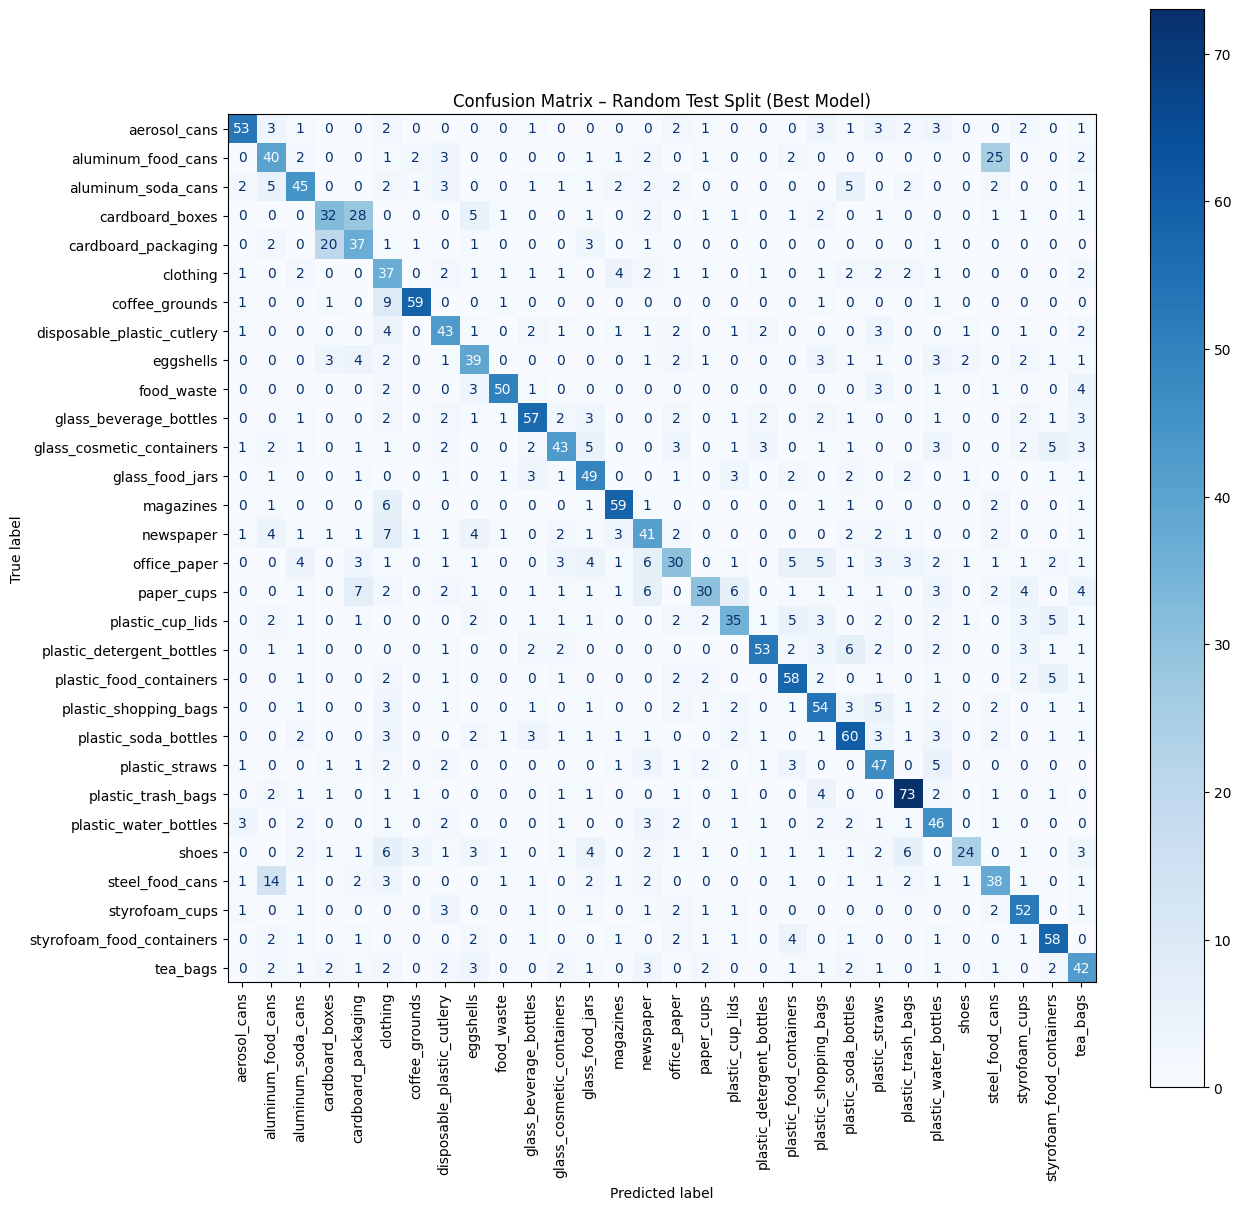

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ✅ Load best model weights from early stopping
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

all_preds = []
all_labels = []

# ✅ Use the random test split to match the training and validation splits
with torch.no_grad():
    for images, labels in random_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Generate and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)

fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix – Random Test Split (Best Model)")
plt.show()


### Accuracy by Category for Model 2

In [24]:
# Load best model weights from early stopping
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Initialize counters
class_correct = [0] * num_classes
class_total = [0] * num_classes

# Evaluate per-class accuracy
with torch.no_grad():
    for images, labels in random_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for label, prediction in zip(labels, predicted):
            class_total[label.item()] += 1
            if label == prediction:
                class_correct[label.item()] += 1

# Print per-class accuracy
print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-"*40)
for i, class_name in enumerate(full_dataset.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")



🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 67.95%
aluminum_food_cans             — Accuracy: 48.78%
aluminum_soda_cans             — Accuracy: 58.44%
cardboard_boxes                — Accuracy: 41.03%
cardboard_packaging            — Accuracy: 55.22%
clothing                       — Accuracy: 56.92%
coffee_grounds                 — Accuracy: 80.82%
disposable_plastic_cutlery     — Accuracy: 65.15%
eggshells                      — Accuracy: 58.21%
food_waste                     — Accuracy: 76.92%
glass_beverage_bottles         — Accuracy: 67.86%
glass_cosmetic_containers      — Accuracy: 53.75%
glass_food_jars                — Accuracy: 70.00%
magazines                      — Accuracy: 80.82%
newspaper                      — Accuracy: 51.90%
office_paper                   — Accuracy: 37.50%
paper_cups                     — Accuracy: 39.47%
plastic_cup_lids               — Accuracy: 49.30%
plastic_detergent_bottles 

### Total Accuracy for Model 2

In [25]:
correct = sum(class_correct)
total = sum(class_total)
overall_acc = 100 * correct / total
print(f"\n✅ Overall Test Accuracy: {overall_acc:.2f}%")



✅ Overall Test Accuracy: 61.51%


## TRAINING for MODEL 3: SAME as above except using double stratified data split

### MODEL: SAME as above

In [26]:
# ----------------------
# IMPORTS
# ----------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# MODEL DEFINITION (with dropout)
# ----------------------
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.5)  # Dropout added to reduce overfitting

        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# ----------------------
# MODEL INITIALIZATION
# ----------------------
num_classes = len(full_dataset.classes)
model = WasteClassifierCNN(num_classes=num_classes).to(device)

# ----------------------
# DATA LOADERS (Double Stratified)
# ----------------------
batch_size = 32
train_loader = DataLoader(double_strat_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(double_strat_val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(double_strat_test_dataset, batch_size=batch_size, shuffle=False)

# ----------------------
# LOSS FUNCTION & OPTIMIZER (with L2 regularization)
# ----------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

# ----------------------
# TRAINING LOOP with Early Stopping & Validation
# ----------------------
num_epochs = 10
patience = 2
best_val_loss = float("inf")
epochs_without_improvement = 0
history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    loop = tqdm(train_loader, total=len(train_loader), leave=True, ncols=100)

    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    # Average training loss
    avg_train_loss = running_loss / len(train_loader)
    history["loss"].append(avg_train_loss)

    # ----------------------
    # VALIDATION PHASE
    # ----------------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)

    print(f"🔍 Validation Loss: {avg_val_loss:.4f}")

    # ----------------------
    # EARLY STOPPING LOGIC
    # ----------------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model_double_strat.pt")  # Save best model
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("⏹️ Early stopping triggered.")
            break

Using device: cpu

Epoch 1/10


100%|████████████████████████████████████| 329/329 [04:46<00:00,  1.15it/s, acc=0.1275, loss=3.1648]


🔍 Validation Loss: 2.6945

Epoch 2/10


100%|████████████████████████████████████| 329/329 [04:49<00:00,  1.13it/s, acc=0.3147, loss=2.4747]


🔍 Validation Loss: 2.1525

Epoch 3/10


100%|████████████████████████████████████| 329/329 [04:50<00:00,  1.13it/s, acc=0.4597, loss=1.9175]


🔍 Validation Loss: 1.8329

Epoch 4/10


100%|████████████████████████████████████| 329/329 [04:49<00:00,  1.14it/s, acc=0.5923, loss=1.4098]


🔍 Validation Loss: 1.6081

Epoch 5/10


100%|████████████████████████████████████| 329/329 [04:49<00:00,  1.14it/s, acc=0.7002, loss=1.0143]


🔍 Validation Loss: 1.6088

Epoch 6/10


100%|████████████████████████████████████| 329/329 [04:53<00:00,  1.12it/s, acc=0.7603, loss=0.7989]


🔍 Validation Loss: 1.5754

Epoch 7/10


100%|████████████████████████████████████| 329/329 [04:49<00:00,  1.14it/s, acc=0.8152, loss=0.6025]


🔍 Validation Loss: 1.7321

Epoch 8/10


100%|████████████████████████████████████| 329/329 [04:50<00:00,  1.13it/s, acc=0.8487, loss=0.4944]


🔍 Validation Loss: 1.7608
⏹️ Early stopping triggered.


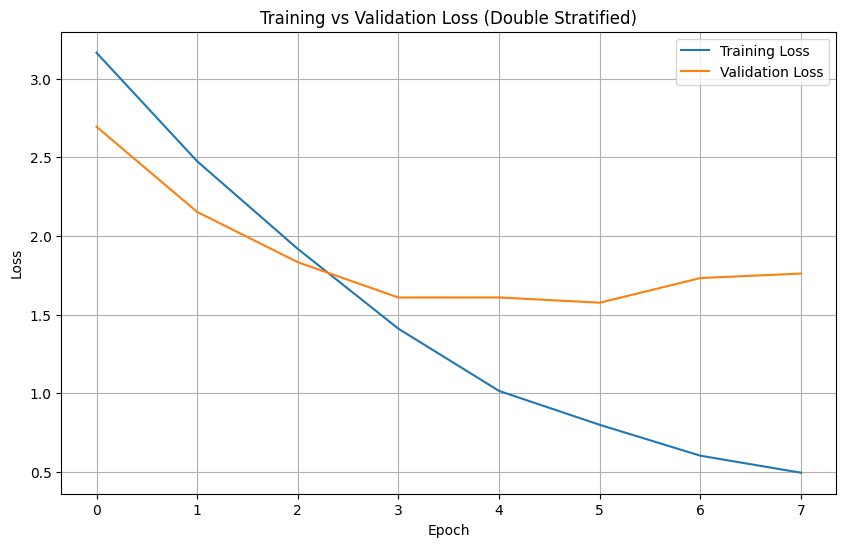

In [27]:
# ----------------------
# PLOT TRAINING vs VALIDATION LOSS
# ----------------------
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Double Stratified)")
plt.legend()
plt.grid(True)
plt.show()


### Confusion Matrix for Model 3

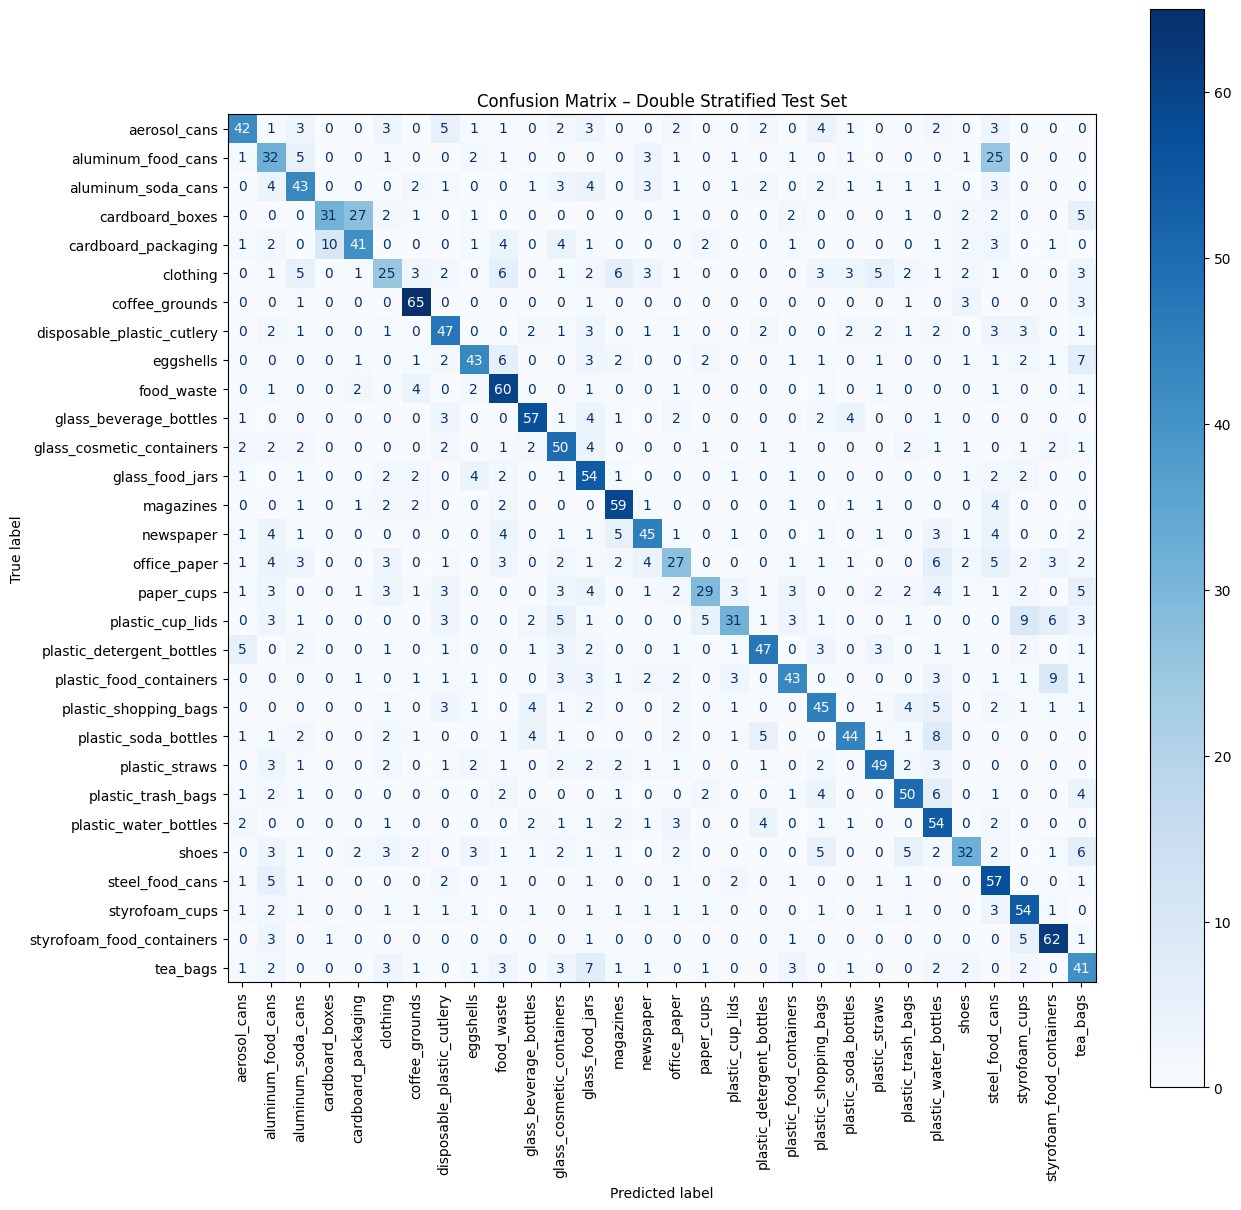

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ✅ Load best saved model (from early stopping)
model.load_state_dict(torch.load("best_model_double_strat.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  # Uses double_strat_test_dataset
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)

fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix – Double Stratified Test Set")
plt.show()


### Accuracy by Category for Model 2

In [29]:
# Reuse same model with best weights from training
model.load_state_dict(torch.load("best_model_double_strat.pt"))
model.eval()

class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for label, prediction in zip(labels, predicted):
            class_total[label] += 1
            if label == prediction:
                class_correct[label] += 1

print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-"*40)
for i, class_name in enumerate(full_dataset.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")



🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 56.00%
aluminum_food_cans             — Accuracy: 42.67%
aluminum_soda_cans             — Accuracy: 58.11%
cardboard_boxes                — Accuracy: 41.33%
cardboard_packaging            — Accuracy: 55.41%
clothing                       — Accuracy: 32.89%
coffee_grounds                 — Accuracy: 87.84%
disposable_plastic_cutlery     — Accuracy: 62.67%
eggshells                      — Accuracy: 57.33%
food_waste                     — Accuracy: 80.00%
glass_beverage_bottles         — Accuracy: 75.00%
glass_cosmetic_containers      — Accuracy: 65.79%
glass_food_jars                — Accuracy: 72.00%
magazines                      — Accuracy: 78.67%
newspaper                      — Accuracy: 59.21%
office_paper                   — Accuracy: 36.49%
paper_cups                     — Accuracy: 38.67%
plastic_cup_lids               — Accuracy: 41.33%
plastic_detergent_bottles 

### Total Accuracy for Model 3

In [30]:
correct = sum(class_correct)
total = sum(class_total)
overall_acc = 100 * correct / total
print(f"\n✅ Overall Test Accuracy: {overall_acc:.2f}%")


✅ Overall Test Accuracy: 60.40%


## Model 4: SAME as above but use DvRW data split

In [31]:
# ----------------------
# IMPORTS, DEVICE, MODEL, LOADER, TRAINING W/ EARLY STOPPING
# ----------------------

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model definition with dropout
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Init model
num_classes = len(full_dataset.classes)
model = WasteClassifierCNN(num_classes=num_classes).to(device)

# Loaders (Default vs Real World)
batch_size = 32
drw_train_loader = DataLoader(drw_train_dataset, batch_size=batch_size, shuffle=True)
drw_val_loader = DataLoader(drw_val_dataset, batch_size=batch_size, shuffle=False)
drw_test_loader = DataLoader(drw_test_dataset, batch_size=batch_size, shuffle=False)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

# Training loop with early stopping
num_epochs = 30
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(drw_train_loader, total=len(drw_train_loader), leave=True, ncols=100)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix({"acc": f"{(correct / total):.4f}", "loss": f"{running_loss / (loop.n + 1):.4f}"})

    train_loss = running_loss / len(drw_train_loader)
    history["loss"].append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in drw_val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(drw_val_loader)
    history["val_loss"].append(val_loss)

    print(f"Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model_drw.pt")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

Using device: cpu


100%|████████████████████████████████████| 329/329 [04:43<00:00,  1.16it/s, acc=0.1743, loss=2.9758]


Validation Loss: 2.6172


100%|████████████████████████████████████| 329/329 [04:45<00:00,  1.15it/s, acc=0.3674, loss=2.2459]


Validation Loss: 2.2069


100%|████████████████████████████████████| 329/329 [04:50<00:00,  1.13it/s, acc=0.5386, loss=1.6215]


Validation Loss: 1.8604


100%|████████████████████████████████████| 329/329 [04:52<00:00,  1.13it/s, acc=0.6636, loss=1.1306]


Validation Loss: 1.7003


100%|████████████████████████████████████| 329/329 [04:48<00:00,  1.14it/s, acc=0.7506, loss=0.8141]


Validation Loss: 1.7201


100%|████████████████████████████████████| 329/329 [04:48<00:00,  1.14it/s, acc=0.8078, loss=0.5976]


Validation Loss: 1.7863


100%|████████████████████████████████████| 329/329 [04:51<00:00,  1.13it/s, acc=0.8510, loss=0.4912]


Validation Loss: 1.7141


100%|████████████████████████████████████| 329/329 [04:49<00:00,  1.14it/s, acc=0.8731, loss=0.4143]


Validation Loss: 1.9884


100%|████████████████████████████████████| 329/329 [04:54<00:00,  1.12it/s, acc=0.8838, loss=0.3698]


Validation Loss: 2.0434
Early stopping triggered.


### Check for Overfitting, Model 4

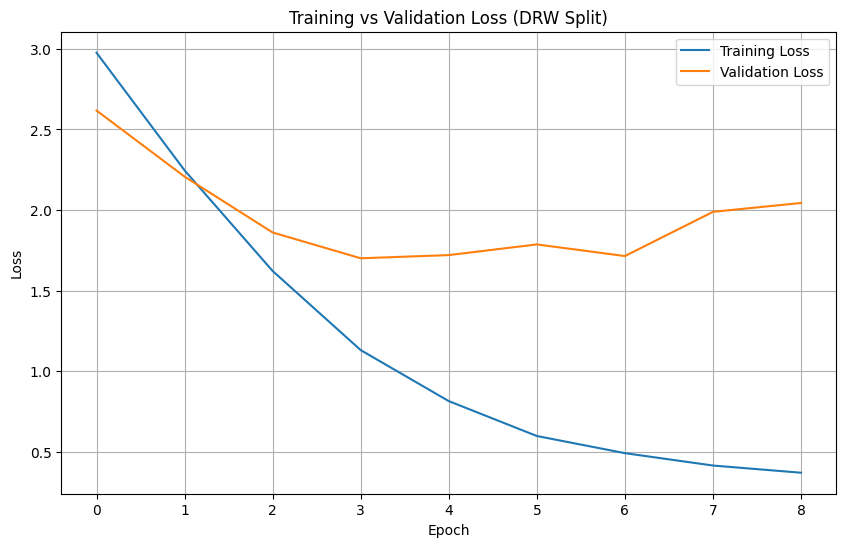

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (DRW Split)")
plt.legend()
plt.grid(True)
plt.show()


### Confusion Matrix for Model 4

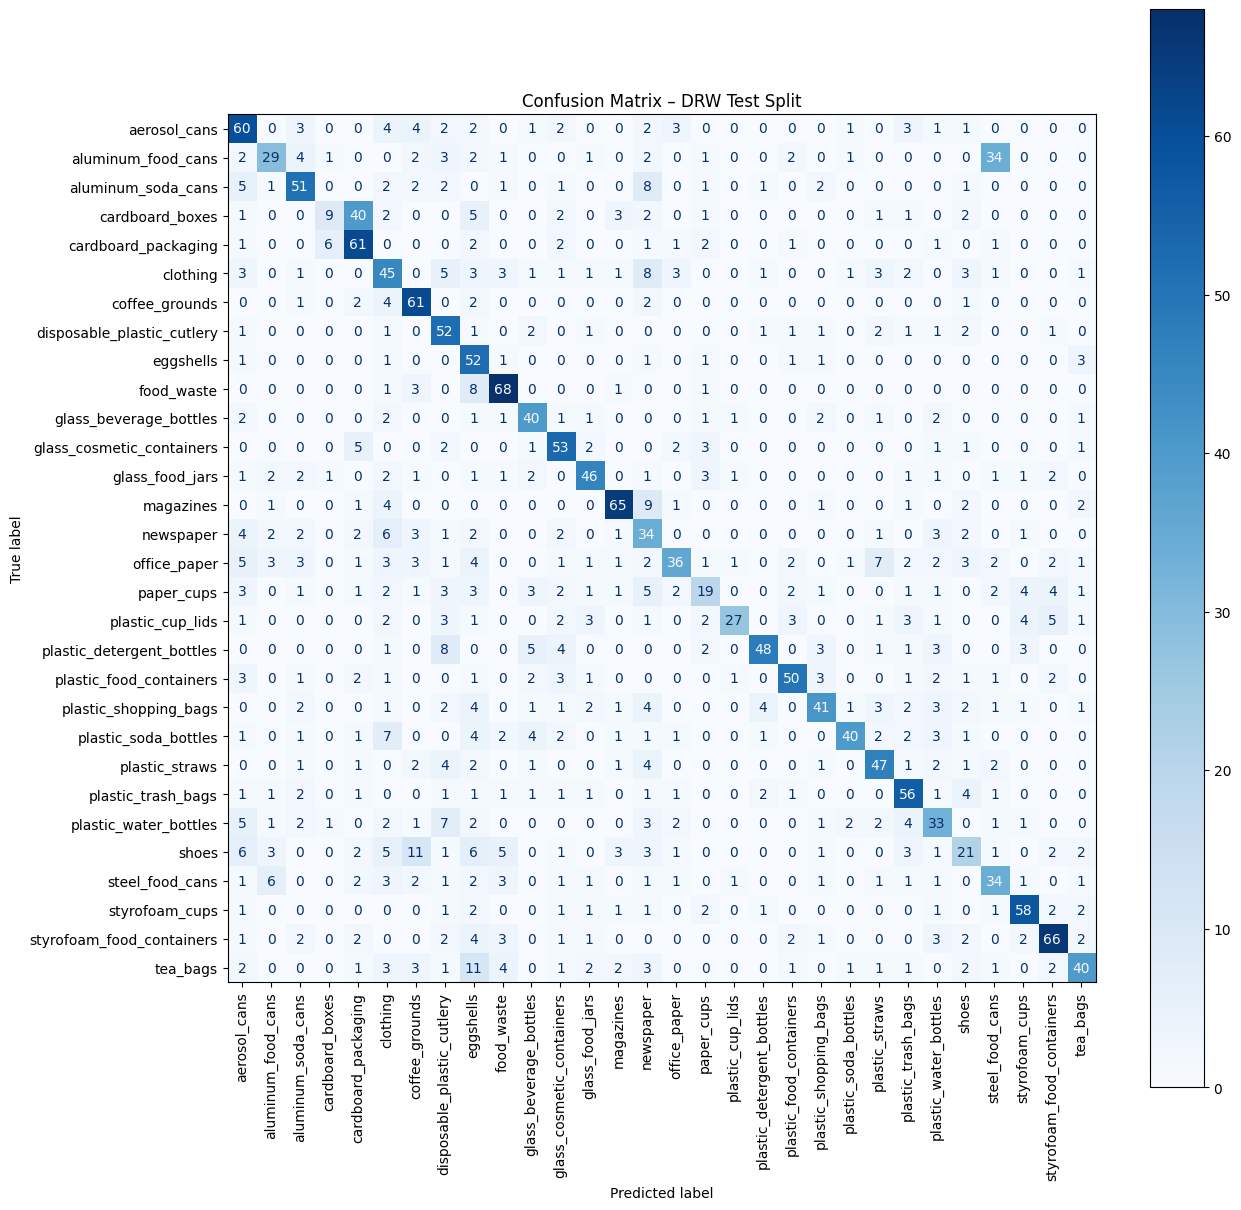

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load best model
model.load_state_dict(torch.load("best_model_drw.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in drw_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)

fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix – DRW Test Split")
plt.show()


### Accuracy by Category for Model 4

In [34]:
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for images, labels in drw_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for label, prediction in zip(labels, predicted):
            class_total[label] += 1
            if label == prediction:
                class_correct[label] += 1

print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-"*40)
for i, class_name in enumerate(full_dataset.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")



🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 67.42%
aluminum_food_cans             — Accuracy: 34.12%
aluminum_soda_cans             — Accuracy: 65.38%
cardboard_boxes                — Accuracy: 13.04%
cardboard_packaging            — Accuracy: 77.22%
clothing                       — Accuracy: 51.72%
coffee_grounds                 — Accuracy: 83.56%
disposable_plastic_cutlery     — Accuracy: 76.47%
eggshells                      — Accuracy: 83.87%
food_waste                     — Accuracy: 82.93%
glass_beverage_bottles         — Accuracy: 71.43%
glass_cosmetic_containers      — Accuracy: 74.65%
glass_food_jars                — Accuracy: 65.71%
magazines                      — Accuracy: 74.71%
newspaper                      — Accuracy: 51.52%
office_paper                   — Accuracy: 40.91%
paper_cups                     — Accuracy: 30.16%
plastic_cup_lids               — Accuracy: 45.00%
plastic_detergent_bottles 

### Totaly Accuracy for Model 4

In [35]:
correct = sum(class_correct)
total = sum(class_total)
overall_acc = 100 * correct / total
print(f"\n✅ Overall Test Accuracy (DRW): {overall_acc:.2f}%")


✅ Overall Test Accuracy (DRW): 59.64%


## MODEL 5: Same Model, Same Anti-Overfitting, Using Image Modifications and Increasing Epochs, Uses Random Split

Using device: cpu


Epoch 1 | Train Loss: 3.4177 | Val Loss: 3.4015


Epoch 2 | Train Loss: 3.4016 | Val Loss: 3.3939


Epoch 3 | Train Loss: 3.3318 | Val Loss: 3.1859


Epoch 4 | Train Loss: 3.1201 | Val Loss: 2.8820


Epoch 5 | Train Loss: 2.9376 | Val Loss: 2.8182


Epoch 6 | Train Loss: 2.7912 | Val Loss: 2.6086


Epoch 7 | Train Loss: 2.7276 | Val Loss: 2.4733


Epoch 8 | Train Loss: 2.6325 | Val Loss: 2.4004


Epoch 9 | Train Loss: 2.5768 | Val Loss: 2.3359


Epoch 10 | Train Loss: 2.5192 | Val Loss: 2.2651


Epoch 11 | Train Loss: 2.4620 | Val Loss: 2.2483


Epoch 12 | Train Loss: 2.4428 | Val Loss: 2.1805


Epoch 13 | Train Loss: 2.3903 | Val Loss: 2.1768


Epoch 14 | Train Loss: 2.3721 | Val Loss: 2.1101


Epoch 15 | Train Loss: 2.3202 | Val Loss: 2.0929


Epoch 16 | Train Loss: 2.3075 | Val Loss: 2.0563


Epoch 17 | Train Loss: 2.2892 | Val Loss: 2.0748


Epoch 18 | Train Loss: 2.2632 | Val Loss: 1.9873


Epoch 19 | Train Loss: 2.2196 | Val Loss: 2.0135


Epoch 20 | Train Loss: 2.2003 | Val Loss: 2.0098


Epoch 21 | Train Loss: 2.2049 | Val Loss: 1.9696


Epoch 22 | Train Loss: 2.1832 | Val Loss: 1.9485


Epoch 23 | Train Loss: 2.1456 | Val Loss: 1.9576


Epoch 24 | Train Loss: 2.1381 | Val Loss: 1.9110


Epoch 25 | Train Loss: 2.1038 | Val Loss: 1.9468


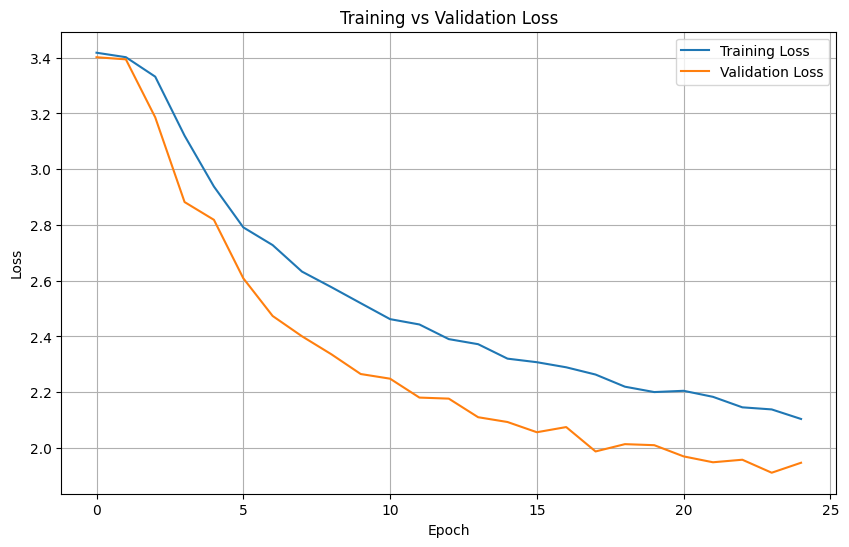

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# DATA AUGMENTATION TRANSFORMS (for training set only)
# ----------------------
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),                  # Randomly flip image horizontally
    transforms.RandomRotation(15),                      # Rotate image by ±15 degrees
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),# Randomly zoom into the image
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Slight brightness/contrast tweaks
    transforms.ToTensor(),                              # Convert PIL to tensor
])

transform_val = transforms.ToTensor()  # No augmentation for validation

# ----------------------
# DATASET LOADING
# ----------------------
# You must re-define the dataset using these transforms for split
augmented_train_dataset = ImageFolder("images/", transform=transform_augmented)
val_dataset = ImageFolder("images/", transform=transform_val)

# Use previous index splits from random_train_dataset and random_val_dataset
train_loader = DataLoader(torch.utils.data.Subset(augmented_train_dataset, random_train_dataset.indices), batch_size=32, shuffle=True)
val_loader = DataLoader(torch.utils.data.Subset(val_dataset, random_val_dataset.indices), batch_size=32, shuffle=False)

# ----------------------
# MODEL DEFINITION (with Dropout)
# ----------------------
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.dropout = nn.Dropout(p=0.5)  # Randomly zeroes 50% of neurons during training
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Applies dropout during training only
        x = self.fc2(x)
        return x

# ----------------------
# INITIALIZATION
# ----------------------
num_classes = len(augmented_train_dataset.classes)
model = WasteClassifierCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# ----------------------
# TRAINING LOOP (with Early Stopping + Val Loss Tracking)
# ----------------------
num_epochs = 25
patience = 3
best_val_loss = float('inf')
patience_counter = 0
history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, total=len(train_loader), leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    # Training Loss
    train_loss = running_loss / len(train_loader)
    history["loss"].append(train_loss)

    # Validation Loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# ----------------------
# PLOT LOSS CURVES
# ----------------------
plt.figure(figsize=(10, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [43]:
# ----------------------
# ACCURACY: Per-Class + Real-World vs Default Breakdown
# ----------------------

# Correct test loader (no augmentation)
test_loader = DataLoader(torch.utils.data.Subset(val_dataset, random_test_dataset.indices), batch_size=32, shuffle=False)

class_correct = [0] * num_classes
class_total = [0] * num_classes

default_correct = 0
default_total = 0
real_correct = 0
real_total = 0

# Get file paths for all test indices
test_paths = [val_dataset.samples[i][0] for i in random_test_dataset.indices]

# Disable gradient computation
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(len(labels)):
            true_label = labels[j]
            pred_label = predicted[j]
            class_total[true_label] += 1
            if true_label == pred_label:
                class_correct[true_label] += 1

            # Path of the current sample (use index from test_loader batch + base i)
            img_index = i * test_loader.batch_size + j
            path = test_paths[img_index]
            if "default" in path:
                default_total += 1
                if true_label == pred_label:
                    default_correct += 1
            elif "real_world" in path:
                real_total += 1
                if true_label == pred_label:
                    real_correct += 1

# ----------------------
# PER-CLASS ACCURACY
# ----------------------
print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-" * 40)
for i, class_name in enumerate(augmented_train_dataset.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")

# ----------------------
# DEFAULT vs REAL-WORLD ACCURACY
# ----------------------
default_acc = 100 * default_correct / default_total if default_total > 0 else 0.0
real_acc = 100 * real_correct / real_total if real_total > 0 else 0.0

print("\n📸 Accuracy by Photo Type:\n" + "-" * 40)
print(f"Default Photos      — Accuracy: {default_acc:.2f}% ({default_correct}/{default_total})")
print(f"Real-World Photos   — Accuracy: {real_acc:.2f}% ({real_correct}/{real_total})")



🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 26.92%
aluminum_food_cans             — Accuracy: 69.51%
aluminum_soda_cans             — Accuracy: 18.18%
cardboard_boxes                — Accuracy: 25.64%
cardboard_packaging            — Accuracy: 61.19%
clothing                       — Accuracy: 40.00%
coffee_grounds                 — Accuracy: 84.93%
disposable_plastic_cutlery     — Accuracy: 40.91%
eggshells                      — Accuracy: 41.79%
food_waste                     — Accuracy: 84.62%
glass_beverage_bottles         — Accuracy: 53.57%
glass_cosmetic_containers      — Accuracy: 17.50%
glass_food_jars                — Accuracy: 57.14%
magazines                      — Accuracy: 73.97%
newspaper                      — Accuracy: 41.77%
office_paper                   — Accuracy: 16.25%
paper_cups                     — Accuracy: 32.89%
plastic_cup_lids               — Accuracy: 23.94%
plastic_detergent_bottles 

In [41]:
correct = sum(class_correct)
total = sum(class_total)
overall_acc = 100 * correct / total
print(f"\n✅ Overall Test Accuracy (Random Split): {overall_acc:.2f}%")


✅ Overall Test Accuracy (Random Split): 44.67%


## Build CNN

In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
#!pip install tensorflow matplotlib scikit-learn

In [5]:
from torch.utils.data import random_split

# 80-20 split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [6]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # Placeholder for fc1 — we'll initialize it after knowing the flatten size
        self._flattened_size = None
        self.fc1 = None
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)

        # Initialize fc1 if we haven't yet
        if self.fc1 is None:
            self._flattened_size = x.shape[1]
            self.fc1 = nn.Linear(self._flattened_size, 128).to(x.device)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [8]:
num_classes = len(full_dataset.classes)
model = WasteClassifierCNN(num_classes)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 7

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%")

Epoch 1, Loss: 1065.459, Train Accuracy: 20.75%
Epoch 2, Loss: 1026.542, Train Accuracy: 23.36%
Epoch 3, Loss: 1002.822, Train Accuracy: 24.92%
Epoch 4, Loss: 979.822, Train Accuracy: 26.45%
Epoch 5, Loss: 963.695, Train Accuracy: 27.52%
Epoch 6, Loss: 945.578, Train Accuracy: 28.23%
Epoch 7, Loss: 928.535, Train Accuracy: 30.22%


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.20      0.09      0.12       110
        aluminum_food_cans       0.26      0.16      0.19       116
        aluminum_soda_cans       0.29      0.21      0.25       103
           cardboard_boxes       0.38      0.56      0.45       113
       cardboard_packaging       0.33      0.18      0.23       106
                  clothing       0.35      0.30      0.32       105
            coffee_grounds       0.52      0.80      0.63        85
disposable_plastic_cutlery       0.34      0.17      0.23        94
                 eggshells       0.29      0.23      0.26       100
                food_waste       0.33      0.62      0.43        99
    glass_beverage_bottles       0.34      0.43      0.38       102
 glass_cosmetic_containers       0.24      0.33      0.28        99
           glass_food_jars       0.38      0.37      0.38       100
                 magazin